<a href="https://colab.research.google.com/github/falawar7/AAI_633O/blob/main/Week2/FE_Implementing_a_Simple_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 2 Hands-on Lab: Implementing and Exploring a Basic GAN**

**Introduction:** This exercise you understand the adversarial training mechanism of GANs by implementing a simple GAN using TensorFlow. You will learn how the generator and discriminator interact, visualize the outputs at different training stages, and evaluate the results.

**Step 1: Setup Your Environment**

Import the needed libraries.




In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt


**Step 2: Prepare the Dataset**

Use the MNIST dataset of handwritten digits.

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train / 255.0

# Flatten the images
#x_train = x_train.reshape(x_train.shape[0], -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Step 3: Build the Generator**

The generator takes random noise as input and outputs a fake image.


In [4]:
def build_generator():
    model = Sequential([
        Dense(128, activation='relu', input_dim=100),
        Dense(784, activation='sigmoid'),
        Reshape((28, 28))
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Step 4: Build the Discriminator**

The discriminator evaluates whether an image is real or fake.


In [5]:
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Step 5: Combine the Models for GAN Training**

Combine the generator and discriminator into a GAN.


In [6]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during generator training
    model = Sequential([generator, discriminator])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

gan = build_gan(generator, discriminator)


In [7]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28)              │         114,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         100,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,673 (838.57 KB)

 Trainable params: 114,064 (445.56 KB)

 Non-trainable params: 100,609 (393.00 KB)

**Step 6: Train the GAN**

Train the generator and discriminator in an adversarial setup.


In [8]:
# Initialize lists to store losses
d_losses = []
g_losses = []

In [9]:
def train_gan(generator, discriminator, gan, data, epochs=1000, batch_size=32):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_images = data[idx]
        fake_images = generator.predict(np.random.normal(0, 1, (half_batch, 100)))

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_losses.append(d_loss[0])

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)
        g_losses.append(g_loss)

        # Print losses every 100 epochs
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

**Step 7: Visualize Generated Images**

Generate and visualize images from the trained generator.


In [10]:
def generate_and_plot_images(generator, examples=10):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=(15, 2))
    for i in range(examples):
        plt.subplot(1, examples, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

def plot_loss_graphs():
    plt.figure(figsize=(12, 8))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Discriminator and Generator Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_graph.png')
    plt.show()

In [11]:
train_gan(generator, discriminator, gan, x_train, epochs=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7003872394561768] [G loss: 0.23846007883548737]
Epoch 1/1000 [D loss: 0.7003872394561768] [G loss: 0.23846007883548737]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 2/1000 [D loss: 0.9390301704406738] [G loss: 0.20451122522354126]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 3/1000 [D loss: 1.0344845056533813] [G loss: 0.1795324832201004]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 4/1000 [D loss: 1.112072467803955] [G loss: 0.15971088409423828]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 5/1000 [D loss: 1.1881965398788452] [G loss: 0.142909437417984]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 6/1000 [D loss: 1.257328748703003] [G loss: 0.1286596804857254]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 7/1000 [D loss: 1.3258576393127441] [G loss: 0.11737467348575592]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 8/1000 [D loss: 1.3907312154769897] [G loss: 0.10725709050893784]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 9/1000 [D loss: 1.4520561695098877] [G loss: 0.098751306533

#**Plotting The Genertaed Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


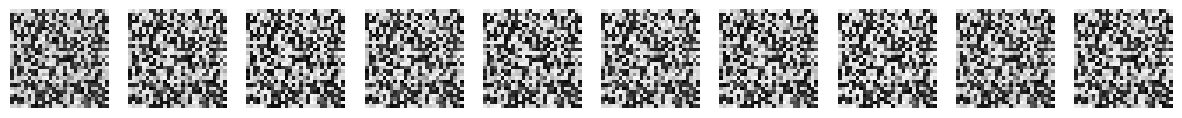

D loss: 4.6284
G loss: 0.0013


In [12]:
generate_and_plot_images(generator)
print(f"D loss: {d_losses[-1]:.4f}\nG loss: {g_losses[-1]:.4f}")

# **Plotting the Loss Graph**

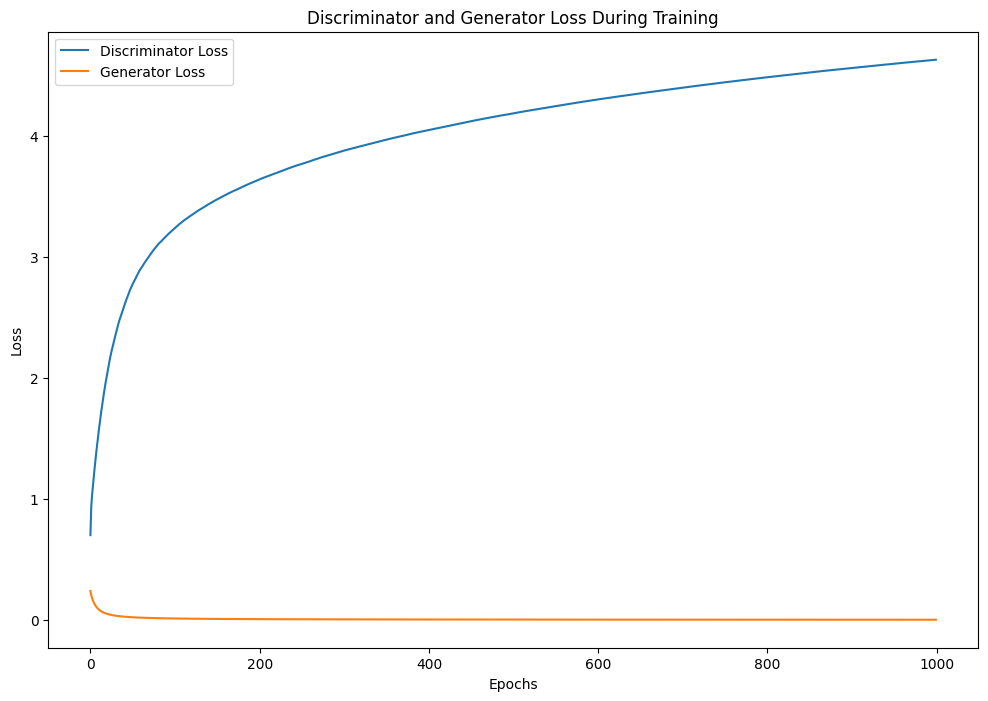

In [13]:
plot_loss_graphs()

#**Trainning Again to Check and Evaluate**

In [14]:
train_gan(generator, discriminator, gan, x_train, epochs=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0 [D loss: 4.62907600402832] [G loss: 0.0012909193756058812]
Epoch 1/1000 [D loss: 4.62907600402832] [G loss: 0.0012909193756058812]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 2/1000 [D loss: 4.6297807693481445] [G loss: 0.0012896760599687696]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 3/1000 [D loss: 4.63044548034668] [G loss: 0.0012884350726380944]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 4/1000 [D loss: 4.631134986877441] [G loss: 0.0012871925719082355]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 5/1000 [D loss: 4.631830215454102] [G loss: 0.0012859568232670426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 6/1000 [D loss: 4.6325225830078125] [G loss: 0.0012847203761339188]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 7/1000 [D loss: 4.633188247680664] [G loss: 0.0012834900990128517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 8/1000 [D loss: 4.63386344909668] [G loss: 0.0012822571443393826]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 9/1000 [

#**Plotting The NEW Genertaed Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


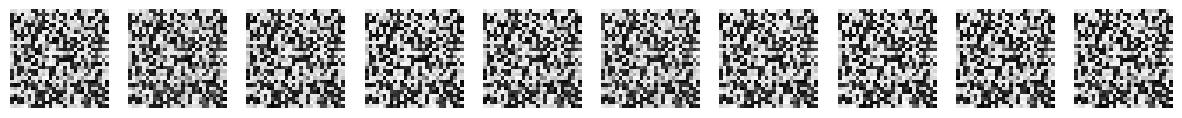

D loss: 5.0879
G loss: 0.0007


In [15]:
generate_and_plot_images(generator)
print(f"D loss: {d_losses[-1]:.4f}\nG loss: {g_losses[-1]:.4f}")

# **Plotting the NEW Loss Graph**

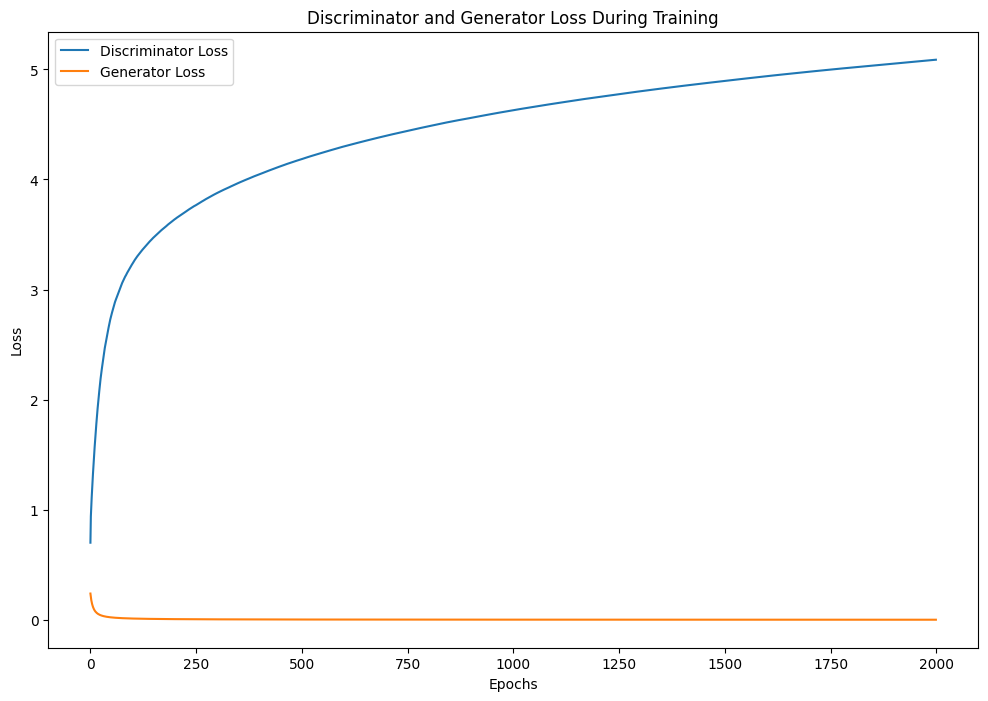

In [16]:
plot_loss_graphs()